In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from copy import deepcopy
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import sys

In [2]:
# node class that each spot in the map will occupy
# cell location and goal_location are tuples representing index 
# of current cell location and goal cell locations
class Node:
    def __init__(self, parent, cell_location, region, c2c, c2g):
        self.parent = parent
        self.cell_location = cell_location
        self.region = region
        self.c2c = c2c
        self.c2g = c2g
        self.h = c2c+c2g

In [3]:
# given 2 points of a line, retrun a lambda function which caluclates the 
# y value of an x
def generate_line_eq(p1, p2):
    
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    m = (y2-y1)/(x2-x1)
    b = y1-m*x1
    
    lin_func = lambda x: m*x+b
    
    return lin_func

In [4]:
# read the board and depending on each nodes status
# write the proper color in a numpy array as BGR colors
def create_color_map(height, width, radius):

    color_map = np.zeros(shape=[height, width, 3], dtype=np.uint8)

    for row in range(height):
        for col in range(width):
            if check_obstacle(col, row):
                color_map[row][col][0] = 255
                color_map[row][col][1] = 0
                color_map[row][col][2] = 0

            else:
                color_map[row][col][0] = 0
                color_map[row][col][1] = 0
                color_map[row][col][2] = 0


    color_map = generate_margin(color_map, radius)
    return color_map

In [5]:
# hardcoded obstacles defined by their vertices and origins
# we just see if the current x and y are within bounding lines
def check_obstacle(x, y):
    
    # check circle
    if y <= 225 and y >= 145 and x <= np.sqrt(40**2 - (y-185)**2) + 300 and x >= -np.sqrt(40**2 - (y-185)**2) + 300:
        return True
    
    # check triangles
    t1_line = generate_line_eq((36, 185), (115, 210))
    t2_line = generate_line_eq((36, 185), (102, 100))
    t3_line = generate_line_eq((80, 180), (115, 210))
    t4_line = generate_line_eq((80, 180), (105, 100))
    if x in range(36, 81):
        if y in range(int(np.floor(t2_line(int(x)))), int(np.ceil(t1_line(int(x))))+1):
            return True
    if x in range(80, 116):
        if y in range(int(np.floor(t3_line(int(x)))), int(np.ceil(t1_line(int(x))))+1):
            return True
    if x in range(80, 106):
        if y in range(int(np.floor(t2_line(int(x)))), int(np.ceil(t4_line(int(x))))+1):
            return True
    
    # check hexagon
    x_h = 200
    y_h = 100
    a = 35
    s = int(a*2/np.sqrt(3))
    
    h1_line = generate_line_eq((x_h-a, y_h+s/2), (x_h,y_h+s))
    h2_line = generate_line_eq((x_h-a, y_h-s/2), (x_h,y_h-s))
    h3_line = generate_line_eq((x_h,y_h+s), (x_h+a, y_h+s/2))
    h4_line = generate_line_eq((x_h,y_h-s), (x_h+a, y_h-s/2))
    
    if x in range(x_h-a, x_h+1):
        if y in range(int(np.floor(h2_line(int(x)))), int(np.ceil(h1_line(int(x))))+1):
            return True
    if x in range(x_h, x_h+a+1):
            if y in range(int(np.floor(h4_line(int(x)))), int(np.ceil(h3_line(int(x))))+1):
                return True

    return False




In [6]:
# iterate over the board, and if the cell is an obstacle, generate 
# the a circle of points around it which are padding
def generate_margin(color_map, radius):

    for y in range(len(color_map)):
        for x in range(len(color_map[y])):

            # read the color map and check to see if the current space is an obstacle
            if (color_map[y][x][0] == 255 and color_map[y][x][1] == 0 and 
                color_map[y][x][2] == 0):

                # generate circle bounds for a point if it is an obstacle
                x_range = range(x-radius, x+radius+1)

                for x_i in x_range:
                    y_upper_limit = np.ceil(np.sqrt(radius**2-(x_i-x)**2) + y)
                    y_lower_limit = np.floor(-np.sqrt(radius**2-(x_i-x)**2) + y)

                    y_range = np.arange(y_lower_limit, y_upper_limit+1)
                    for y_i in y_range:
                        if (x_i >= 0 and x_i <= 399) and (y_i >= 0 and y_i <= 249):
                            if not (color_map[int(y_i)][x_i][0] == [255] and 
                                    color_map[int(y_i)][x_i][1] == [0] and 
                                    color_map[int(y_i)][x_i][2] == [0]):
                                color_map[int(y_i)][x_i] = [0,255,0]
    return color_map


In [7]:
# pass in color map coordinates and convert them to board 
# coordinates which have been compressed/expanded coordinates 
# by the neighborhood threshold

def compress_coordinates(x, y, theta, thresh):
    compressed_x = int(np.floor(x/thresh))
    compressed_y = int(np.floor(y/thresh))
    compressed_angle = 0 if theta == 0 else int(np.floor(360/theta))-1

    return compressed_x, compressed_y, compressed_angle

In [8]:
# will be used when iterating over closed nodes
# updates the previous color map given the current node to a specifies color
def update_color_map(curr_node, color_map, brg_color):

    row = int(np.floor(curr_node.cell_location[0]))
    col = int(np.floor(curr_node.cell_location[1]))

    color_map[row][col][0] = brg_color[0]
    color_map[row][col][1] = brg_color[1]
    color_map[row][col][2] = brg_color[2]

    return color_map

In [9]:
# create the board
# returns a 3d array
# dimensions are height width and angle. Takes in a compressed version of 
# the height width and angle which handles the region/node similarity
def create_board(width, height, thresh):

    compressed_width, compressed_height, compressed_angle = compress_coordinates(x=width, y=height, theta=30, thresh=thresh)

    board = []
    for row_num in range(0, compressed_height):
        temp_row = []
        for col_num in range(0, compressed_width):

            temp_configuration = []
            for angle in range(0,compressed_angle+1):

                c2c = np.Infinity
                c2g = np.Infinity

                # c2g = np.sqrt((row_num-goal_location[0])**2 + (col_num-goal_location[1]**2))

                new_node = Node(parent=None, 
                                c2c=c2c,
                                c2g=c2g,
                                cell_location=[row_num, col_num, angle],
                                region=[row_num, col_num, angle])

                temp_configuration.append(new_node)
            temp_row.append(temp_configuration)
        board.append(temp_row)

    return board

In [10]:
# checking the left most command ie +60 degrees
def check_l2(curr_node, board, goal_location, color_map, step, thresh):
    
    curr_row = curr_node.cell_location[0]
    curr_col = curr_node.cell_location[1]
    curr_angle = curr_node.cell_location[2]
    
    theta_res = (curr_angle + 60)%360

    x_res = float((curr_col + step*np.cos(np.deg2rad(theta_res))))
    y_res = float((curr_row + step*np.sin(np.deg2rad(theta_res))))


    # check left and right border
    if int(np.floor(x_res)) < 0 or int(np.floor(x_res)) > 399:
        return None

    # check up and down border
    if int(np.floor(y_res)) < 0 or int(np.floor(y_res)) > 249:
        return None

    # if resultant space is obstacle or margin
    if ((color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0) or
       (color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0)):

        return None

    c2c = curr_node.c2c + 1
    c2g = np.sqrt((x_res-goal_location[1])**2 + (y_res-goal_location[0])**2)
    h = c2g+c2c
 
    compressed_x, compressed_y, compressed_angle = compress_coordinates(x_res, y_res, theta_res, thresh)
    # print(f"Generating node is location x: {x_res}, y: {y_res}, theta: {theta_res}")
    # print(f"Generating node is region x: {compressed_x}, y: {compressed_y}, theta: {compressed_angle}")


    new_node = board[compressed_y][compressed_x][compressed_angle]

    if h < new_node.h:
        new_node.parent = curr_node
        new_node.cell_location = [y_res, x_res, theta_res]
        new_node.c2c = c2c
        new_node.c2g = c2g
        new_node.h = h
        
    return new_node

In [11]:
# checking the left most command ie 30 degrees
def check_l1(curr_node, board, goal_location, color_map, step, thresh):
    
    curr_row = curr_node.cell_location[0]
    curr_col = curr_node.cell_location[1]
    curr_angle = curr_node.cell_location[2]
    
    theta_res = (curr_angle + 30)%360
    
    x_res = float((curr_col + step*np.cos(np.deg2rad(theta_res))))
    y_res = float((curr_row + step*np.sin(np.deg2rad(theta_res))))


    # check left and right border
    if int(np.floor(x_res)) < 0 or int(np.floor(x_res)) > 399:
        return None

    # check up and down border
    if int(np.floor(y_res)) < 0 or int(np.floor(y_res)) > 249:
        return None

    # if resultant space is obstacle or margin
    if ((color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0) or
       (color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0)):


        return None

    c2c = curr_node.c2c + 1
    c2g = np.sqrt((x_res-goal_location[1])**2 + (y_res-goal_location[0])**2)
    h = c2g+c2c

    compressed_x, compressed_y, compressed_angle = compress_coordinates(x_res, y_res, theta_res, thresh)
    # print(f"Generating node is location x: {x_res}, y: {y_res}, theta: {theta_res}")
    # print(f"Generating node is region x: {compressed_x}, y: {compressed_y}, theta: {compressed_angle}")

    new_node = board[compressed_y][compressed_x][compressed_angle]
    if h < new_node.h:
        new_node.parent = curr_node
        new_node.cell_location = [y_res, x_res, theta_res]
        new_node.c2c = c2c
        new_node.c2g = c2g
        new_node.h = h
        
    return new_node

In [12]:
# checking the middle ie 30 degrees
def check_m(curr_node, board, goal_location, color_map, step, thresh):
    
    curr_row = curr_node.cell_location[0]
    curr_col = curr_node.cell_location[1]
    curr_angle = curr_node.cell_location[2]
    
    theta_res = (curr_angle)%360
    
    x_res = float((curr_col + step*np.cos(np.deg2rad(theta_res))))
    y_res = float((curr_row + step*np.sin(np.deg2rad(theta_res))))

    # check left and right border
    if int(np.floor(x_res)) < 0 or int(np.floor(x_res)) > 399:
        return None

    # check up and down border
    if int(np.floor(y_res)) < 0 or int(np.floor(y_res)) > 249:
        return None

    # if resultant space is obstacle or margin
    if ((color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0) or
       (color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0)):


        return None

    c2c = curr_node.c2c + 1
    c2g = np.sqrt((x_res-goal_location[1])**2 + (y_res-goal_location[0])**2)
    h = c2g+c2c

 
    compressed_x, compressed_y, compressed_angle = compress_coordinates(x_res, y_res, theta_res, thresh)
    # print(f"Generating node is location x: {x_res}, y: {y_res}, theta: {theta_res}")
    # print(f"Generating node is region x: {compressed_x}, y: {compressed_y}, theta: {compressed_angle}")

    new_node = board[compressed_y][compressed_x][compressed_angle]
    if h < new_node.h:
        new_node.parent = curr_node
        new_node.cell_location = [y_res, x_res, theta_res]
        new_node.c2c = c2c
        new_node.c2g = c2g
        new_node.h = h
        
    return new_node

In [13]:
# checking the inside right command ie -30 degrees
def check_r1(curr_node, board, goal_location, color_map, step, thresh):
    
    curr_row = curr_node.cell_location[0]
    curr_col = curr_node.cell_location[1]
    curr_angle = curr_node.cell_location[2]
    
    theta_res = (curr_angle - 30)%360
    
    x_res = float((curr_col + step*np.cos(np.deg2rad(theta_res))))
    y_res = float((curr_row + step*np.sin(np.deg2rad(theta_res))))


    # check left and right border
    if int(np.floor(x_res)) < 0 or int(np.floor(x_res)) > 399:
        return None

    # check up and down border
    if int(np.floor(y_res)) < 0 or int(np.floor(y_res)) > 249:
        return None

    # if resultant space is obstacle or margin
    if ((color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0) or
       (color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0)):


        return None

    c2c = curr_node.c2c + 1
    c2g = np.sqrt((x_res-goal_location[1])**2 + (y_res-goal_location[0])**2)
    h = c2g+c2c

 
    compressed_x, compressed_y, compressed_angle = compress_coordinates(x_res, y_res, theta_res, thresh)
    # print(f"Generating node is location x: {x_res}, y: {y_res}, theta: {theta_res}")
    # print(f"Generating node is region x: {compressed_x}, y: {compressed_y}, theta: {compressed_angle}")

    new_node = board[compressed_y][compressed_x][compressed_angle]
    if h < new_node.h:
        new_node.parent = curr_node
        new_node.cell_location = [y_res, x_res, theta_res]
        new_node.c2c = c2c
        new_node.c2g = c2g
        new_node.h = h
        
    return new_node

In [14]:
# checking the outside right command ie -60 degrees
def check_r2(curr_node, board, goal_location, color_map, step, thresh):
    
    curr_row = curr_node.cell_location[0]
    curr_col = curr_node.cell_location[1]
    curr_angle = curr_node.cell_location[2]
    
    theta_res = (curr_angle - 60)%360
    
    x_res = float((curr_col + step*np.cos(np.deg2rad(theta_res))))
    y_res = float((curr_row + step*np.sin(np.deg2rad(theta_res))))


    # check left and right border
    if int(np.floor(x_res)) < 0 or int(np.floor(x_res)) > 399:
        return None

    # check up and down border
    if int(np.floor(y_res)) < 0 or int(np.floor(y_res)) > 249:
        return None

    # if resultant space is obstacle or margin
    if ((color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0) or
       (color_map[int(np.floor(y_res))][int(np.floor(x_res))][0] == 0 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][1] == 255 and 
        color_map[int(np.floor(y_res))][int(np.floor(x_res))][2] == 0)):


        return None

    c2c = curr_node.c2c + 1
    c2g = np.sqrt((x_res-goal_location[1])**2 + (y_res-goal_location[0])**2)
    h = c2g+c2c


    compressed_x, compressed_y, compressed_angle = compress_coordinates(x_res, y_res, theta_res, thresh)
    # print(f"Generating node is location x: {x_res}, y: {y_res}, theta: {theta_res}")
    # print(f"Generating node is region x: {compressed_x}, y: {compressed_y}, theta: {compressed_angle}")

    new_node = board[compressed_y][compressed_x][compressed_angle]
    if h < new_node.h:
        new_node.parent = curr_node
        new_node.cell_location = [y_res, x_res, theta_res]
        new_node.c2c = c2c
        new_node.c2g = c2g
        new_node.h = h

    return new_node

In [15]:
# generate next possible nodes for the current one
# filter out null ones which happens in a bpundary condition
def gen_next_nodes(curr_node, board, goal_location, color_map, step, thresh):

    new_nodes = []

    new_nodes.append(check_l2(curr_node, board, goal_location, color_map, step, thresh))
    new_nodes.append(check_l1(curr_node, board, goal_location, color_map, step, thresh))
    new_nodes.append(check_m(curr_node, board, goal_location, color_map, step, thresh))
    new_nodes.append(check_r1(curr_node, board, goal_location, color_map, step, thresh))
    new_nodes.append(check_r2(curr_node, board, goal_location, color_map, step, thresh))

    return list(filter(lambda node: node is not None, new_nodes))


In [16]:
# this is the backtracking function
# returns a list of nodes in order to find the solution
def get_solution_path(curr_node):
    solution_path= []
    
    while curr_node:
        solution_path.insert(0, curr_node)
        curr_node = curr_node.parent
        
    return solution_path

In [17]:
# use cv2 in order to draw how the node 
# traversal looks as well as plot the shortest path

def animate(color_map, closed_nodes, solution_path, filename):
    out = cv2.VideoWriter(f'{filename}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (400, 250))
 
    for node in closed_nodes:
        out.write(np.flipud(update_color_map(node, color_map, [255, 255, 255])))

    for node in solution_path:
        out.write(np.flipud(update_color_map(node, color_map, [0, 0, 255])))
        
    out.release()

In [22]:
start_location = [0,0,0]
goal_location = [100,300,0]

width = 400
height = 250

step = 2
thresh = 0.5

color_map = create_color_map(height = 250, width = 400, radius=15)


if start_location[0] not in range(0, height) or start_location[1] not in range(0, width):
    print("Start Location Out Of Bounds")

if goal_location[0] not in range(0, height) or goal_location[1] not in range(0, width):
    print("Goal Location Out Of Bounds")

if color_map[start_location[0]][start_location[1]][0] == 255 or color_map[start_location[0]][start_location[1]][1] == 255:
    print('Cannot start in obstacle or obstacle margin')

if color_map[goal_location[0]][goal_location[1]][0] == 255 or color_map[goal_location[0]][goal_location[1]][1] == 255:
    print('Cannot place goal in obstacle or obstacle margin')


Starting in region x: 0, y: 0, theta: 0
Goal in region x: 600, y: 200, theta: 0


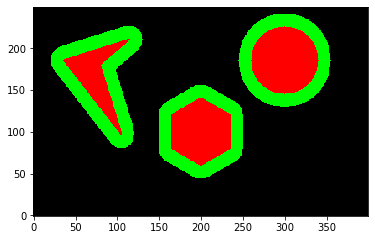

In [23]:
board = create_board(width=width, height=height, thresh=thresh)

compressed_x_start, compressed_y_start, compressed_angle_start = compress_coordinates(
    start_location[1],
    start_location[0],
    start_location[2],
    thresh=thresh
)

compressed_x_goal, compressed_y_goal, compressed_angle_goal = compress_coordinates(
    goal_location[1],
    goal_location[0],
    goal_location[2],
    thresh=thresh
)

print(f'Starting in region x: {compressed_x_start}, y: {compressed_y_start}, theta: {compressed_angle_start}')
print(f'Goal in region x: {compressed_x_goal}, y: {compressed_y_goal}, theta: {compressed_angle_goal}')

plt.imshow(color_map, origin='bottom')

In [24]:
start_node = board[compressed_y_start][compressed_x_start][compressed_angle_start]
start_node.c2c = 0
goal_region = board[compressed_y_goal][compressed_x_goal][compressed_angle_goal].region

open_nodes = [start_node]
closed_nodes = []

found = False

print(f'Searching for goal region: {goal_region}')
while len(open_nodes) > 0:

    open_nodes.sort(key=lambda x: x.h)
    curr_node = open_nodes.pop(0)
    closed_nodes.append(curr_node)

    # print(f"Current node has exact coordinates of x:{curr_node.cell_location[1]} y:{curr_node.cell_location[0]} Theta:{curr_node.cell_location[2]}")
    print(f"Current node is in region coordinates of {curr_node.region}")


    if curr_node.region[:2] == goal_region[:2]:
        print('Found Solution')
        found = True
        break

    else:
        next_possible_nodes = gen_next_nodes(
            curr_node=curr_node,
            board=board,
            goal_location=goal_location,
            color_map=color_map,
            step=step,
            thresh=thresh
        )
        
        for node in next_possible_nodes:

            appendable = True
            for o_node in open_nodes:
                if o_node.region == node.region:
                    appendable = False
                    break
            if appendable:
                for c_node in closed_nodes:
                    if c_node.region == node.region:
                        appendable = False
                        break

            if appendable:
                open_nodes.append(node)

if not found:
    print('No Solution')

Searching for goal region: [200, 600, 0]
Current node is in region coordinates of [0, 0, 0]
Current node is in region coordinates of [1, 3, 11]
Current node is in region coordinates of [3, 6, 11]
Current node is in region coordinates of [5, 10, 11]
Current node is in region coordinates of [7, 13, 11]
Current node is in region coordinates of [9, 17, 11]
Current node is in region coordinates of [11, 20, 11]
Current node is in region coordinates of [13, 24, 11]
Current node is in region coordinates of [15, 27, 11]
Current node is in region coordinates of [17, 31, 11]
Current node is in region coordinates of [19, 34, 11]
Current node is in region coordinates of [21, 38, 11]
Current node is in region coordinates of [23, 41, 11]
Current node is in region coordinates of [25, 45, 11]
Current node is in region coordinates of [27, 48, 11]
Current node is in region coordinates of [29, 51, 11]
Current node is in region coordinates of [31, 55, 11]
Current node is in region coordinates of [33, 58, 1

In [25]:
print('Animating Search Pattern')          
# back track and animate the search and solution
solution_path = get_solution_path(curr_node)
animate(color_map, closed_nodes, solution_path, filename='search')


Animating Search Pattern
